In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
import scipy
scipy.__version__


'1.6.0'

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
subjects = [name for name in os.listdir(data_directory) \
            if os.path.isdir(os.path.join(data_directory, name))]
threshold = (300, 2500)

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

In [5]:
def load_subject(subject, data_directory, threshold1, threshold2, merged_controls=False):
    file_suffix = 'cells_' + str(threshold1) if subject[0] == 'F' else 'cells_' + str(threshold2)
    if merged_controls:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
        if subject[0]=='B':
            df_mouse = ace.reformat_df_mouse(df=df_mouse[df_mouse[' x']>228].reset_index(drop=True))
        else:
            df_mouse = ace.reformat_df_mouse(df=df_mouse)
    else:
        df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
        df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [6]:
def sum_values(subjects, groups):
    data = pd.DataFrame(columns=['subject', 'group', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects]
    data['group'] = [utils.split_string(subject)[-1] for subject in subjects]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        data[metric] = [dict_results_across_mice[subject][metric].sum() \
                        for subject in subjects]
    return data

In [7]:
def dataframe_areas(area, subjects, groups):
    data = pd.DataFrame(columns=['subject', 'n_cells', 'energy', 'density', 'relative_density'])
    data['subject'] = [subject for subject in subjects]
    data['group'] = [utils.split_string(subject)[-1] for subject in subjects]
    for metric in ['n_cells', 'energy', 'density', 'relative_density']:
        values = []
        for subject in subjects:
            v = dict_results_across_mice[subject]
            values.append(v[v['area']==area][metric].values[0])
        data[metric] = [v for v in values]
    return data

In [8]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [9]:
def find_common_pvalues(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                      dict_results_across_mice=dict_results_across_mice, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    find_common_areas = np.unique(np.concatenate([
        df_ttest[df_ttest[col]<alpha]['area'].to_numpy() \
        for col in df_ttest.loc[:, df_ttest.columns!='area'].columns]).ravel())

    df_ttest = df_ttest.set_index('area').loc[find_common_areas]
    df_ttest.columns = [col.replace('pval_', '') for col in columns if col!='area']
    df_ttest = df_ttest.reset_index()
    return df_ttest

In [10]:
def find_pvalues(dictionary, experimental_groups, value, tag, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                      dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    col=tag
    find_areas = df_ttest[df_ttest[col]<alpha]['area'].to_numpy()

    df_ttest = df_ttest.set_index('area').loc[find_areas]
    df_ttest = df_ttest.reset_index()
    df_ttest = df_ttest[['area', tag]]
    return df_ttest

In [11]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_c57_merged_hemispheres.npy', 
                                   allow_pickle=True).item()

In [12]:
subjects = list(dict_results_across_mice.keys())

In [13]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

# Creiamo tabelle con le varie misure

In [14]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [15]:
df_control_cell_count.to_csv('control_ncells.csv', index=False)
df_fam_cell_count.to_csv('fam_ncells.csv', index=False)
df_unfam_cell_count.to_csv('unfam_ncells.csv', index=False)

In [16]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='energy')

In [17]:
df_control_energy.to_csv('control_energy.csv', index=False)
df_fam_energy.to_csv('fam_energy.csv', index=False)
df_unfam_energy.to_csv('unfam_energy.csv', index=False)

In [18]:
df_control_density, df_fam_density, df_unfam_density = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='density')

In [19]:
df_control_density.to_csv('control_density.csv', index=False)
df_fam_density.to_csv('fam_density.csv', index=False)
df_unfam_density.to_csv('unfam_density.csv', index=False)

In [20]:
s_values = sum_values(subjects=subjects, groups=['Control', 'Fam', 'Unfam'])

# N cellule totali

In [21]:
df_control_cell_count.set_index('area').sum()

BL53Control    29084
F10Control     47203
BL45Control    47093
F16Control      7675
BL51Control    44173
F11Control     15406
F1Control      29195
dtype: int64

In [22]:
df_fam_cell_count.set_index('area').sum()

BL49Fam    40180
F7Fam      50726
F15Fam     28414
BL47Fam    45959
F13Fam     25668
F5Fam      26756
BL50Fam    49253
F3Fam      42793
F9Fam      67115
dtype: int64

In [23]:
df_unfam_cell_count.set_index('area').sum()

F6Unfam      175787
F8Unfam       68881
BL48Unfam     43347
F4Unfam       36382
F2Unfam       76009
BL54Unfam     25408
BL52Unfam     29065
BL46Unfam     29777
F12Unfam      41229
F14Unfam      20149
dtype: int64

## Boxplot numero totale di cellule

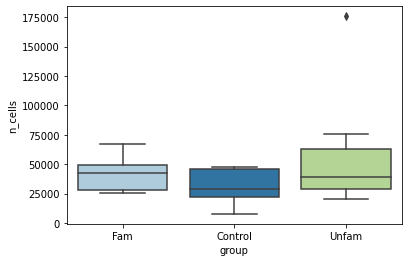

In [24]:
ax = sns.boxplot(data=s_values, y='n_cells', x='group', palette='Paired')
plt.savefig('boxplot_ncells.svg')

# Energia totale

In [25]:
df_control_energy.set_index('area').sum()

BL53Control    1.539908e+08
F10Control     4.584303e+07
BL45Control    3.190426e+08
F16Control     5.374690e+06
BL51Control    2.666885e+08
F11Control     1.250835e+07
F1Control      3.096475e+07
dtype: float64

In [26]:
df_fam_energy.set_index('area').sum()

BL49Fam    2.443567e+08
F7Fam      7.095188e+07
F15Fam     3.575699e+07
BL47Fam    2.929110e+08
F13Fam     3.365159e+07
F5Fam      3.001816e+07
BL50Fam    2.916292e+08
F3Fam      5.132347e+07
F9Fam      6.300211e+07
dtype: float64

In [27]:
df_unfam_energy.set_index('area').sum()

F6Unfam      1.553403e+08
F8Unfam      1.021610e+08
BL48Unfam    2.174758e+08
F4Unfam      4.086200e+07
F2Unfam      1.040455e+08
BL54Unfam    1.356645e+08
BL52Unfam    1.622930e+08
BL46Unfam    1.551062e+08
F12Unfam     5.370439e+07
F14Unfam     3.805825e+07
dtype: float64

## Boxplot energia

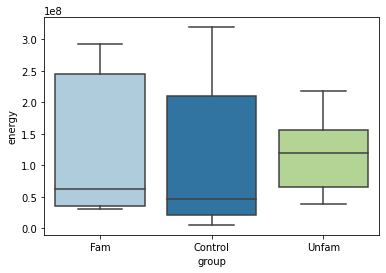

In [28]:
ax = sns.boxplot(data=s_values, y='energy', x='group', palette='Paired')
plt.savefig('boxplot_energy.svg')

# Density

In [29]:
df_control_density.set_index('area').sum()

BL53Control    22114.704779
F10Control     38745.342865
BL45Control    44277.108730
F16Control      5105.207129
BL51Control    39207.880766
F11Control     12170.159825
F1Control      27930.306564
dtype: float64

In [30]:
df_fam_energy.set_index('area').sum()

BL49Fam    2.443567e+08
F7Fam      7.095188e+07
F15Fam     3.575699e+07
BL47Fam    2.929110e+08
F13Fam     3.365159e+07
F5Fam      3.001816e+07
BL50Fam    2.916292e+08
F3Fam      5.132347e+07
F9Fam      6.300211e+07
dtype: float64

In [31]:
df_unfam_energy.set_index('area').sum()

F6Unfam      1.553403e+08
F8Unfam      1.021610e+08
BL48Unfam    2.174758e+08
F4Unfam      4.086200e+07
F2Unfam      1.040455e+08
BL54Unfam    1.356645e+08
BL52Unfam    1.622930e+08
BL46Unfam    1.551062e+08
F12Unfam     5.370439e+07
F14Unfam     3.805825e+07
dtype: float64

## Boxplot density

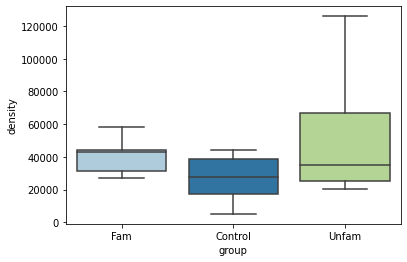

In [32]:
ax = sns.boxplot(data=s_values, y='density', x='group', palette='Paired')
plt.savefig('boxplot_density.svg')

# Boxplot aree

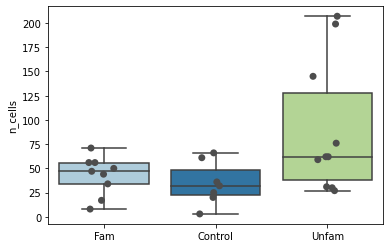

In [33]:
area = 'Supramammillary nucleus'
SuM = dataframe_areas(area=area, 
                      subjects=subjects, 
                      groups=['Control', 'Fam', 'Unfam'])
ax = sns.boxplot(data=SuM, y='n_cells', x='group', palette='Paired')
# Come aggiungere punti su boxplot
ax = sns.stripplot(data=SuM, y='n_cells', x="group", size=7, color=".3", jitter=0.15)
# remove 'group' label
ax.set_xlabel('')
plt.savefig('sum.svg')

# Plot aree significative

In [47]:
for value in ['n_cells', 'energy', 'density']:
    sig_areas = find_significant_areas(dictionary=dict_results_across_mice, 
                           experimental_groups=experimental_groups, 
                           value=value, 
                           test='mannwhitneyu', 
                           alpha=0.05)
    sig_areas.to_csv('significant_areas_'+value+'.csv')

In [49]:
for value in ['n_cells', 'energy', 'density']:
    df = find_common_pvalues(dictionary=dict_results_across_mice, 
                      experimental_groups=experimental_groups, 
                      value='n_cells', test='mannwhitneyu', alpha=0.05)
    df1 = pd.melt(df,
            id_vars='area',
            value_vars=list(df.columns[1:]),
            var_name='group', 
            value_name='pvalue')
    df.to_csv('pvalues_areas'+value+'.csv')
    df.to_csv('pvalues_areas2'+value+'.csv')

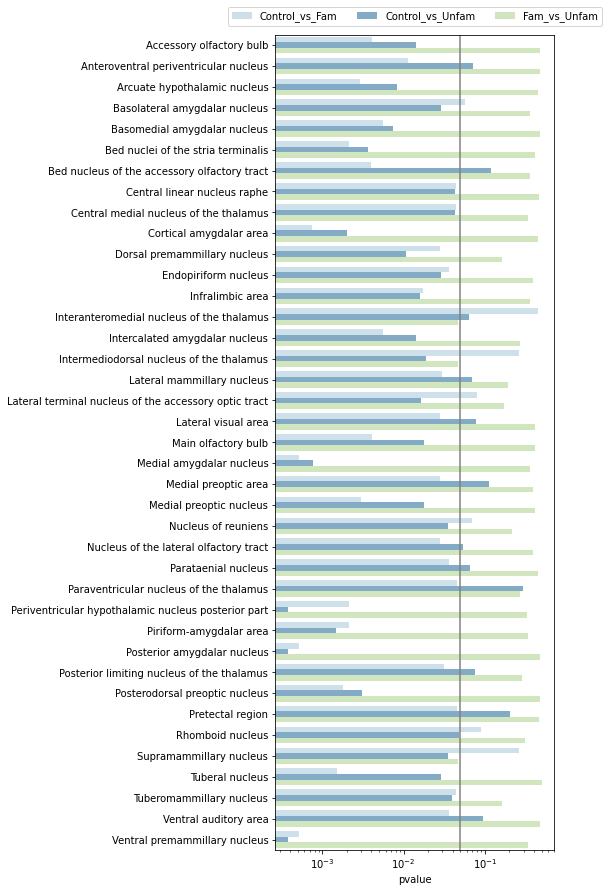

In [42]:
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df1,
    y="area", x="pvalue", hue="group", alpha=.6,
    axes=ax, palette='Paired')
ax.set_xscale("log")
ax.set_ylabel('')
ax.axvline(x=0.05, color='grey')
ax.legend(
loc='upper center', 
bbox_to_anchor=(0.5, 1.04),
ncol=3)
plt.savefig('significant_areas.svg')

# Plot singole aree

## ncells

Text(0, 0.5, '')

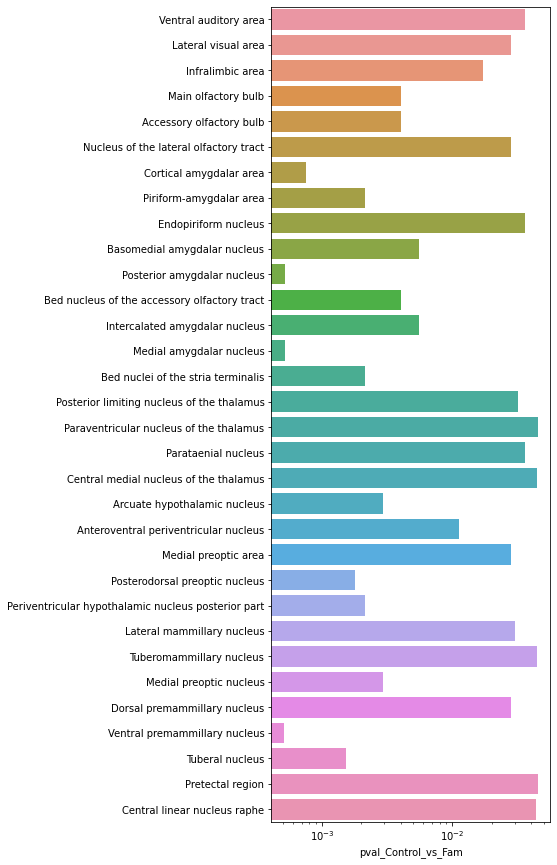

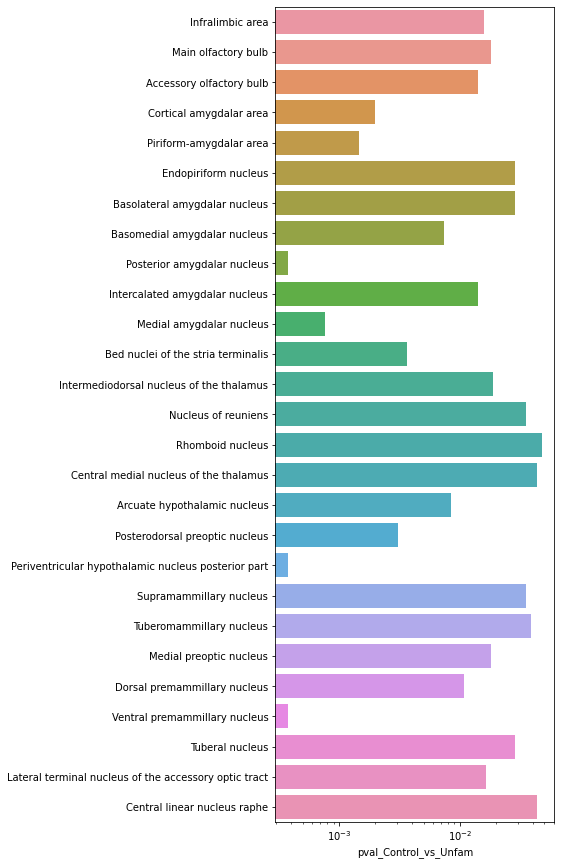

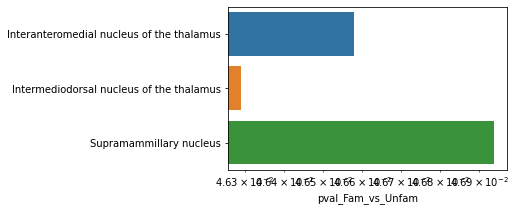

In [70]:
value = 'n_cells'

df_control_fam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Control_vs_Fam', 
             test='mannwhitneyu', alpha=0.05)
df_control_unfam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Control_vs_Unfam', 
             test='mannwhitneyu', alpha=0.05)
df_fam_unfam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Fam_vs_Unfam', 
             test='mannwhitneyu', alpha=0.05)

#plot control fam
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df_control_fam,
    y="area", x="pval_Control_vs_Fam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

#plot control unfam
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df_control_unfam,
    y="area", x="pval_Control_vs_Unfam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

#plot fam unfam
fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.barplot(
    data=df_fam_unfam,
    y="area", x="pval_Fam_vs_Unfam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

## energy

Text(0, 0.5, '')

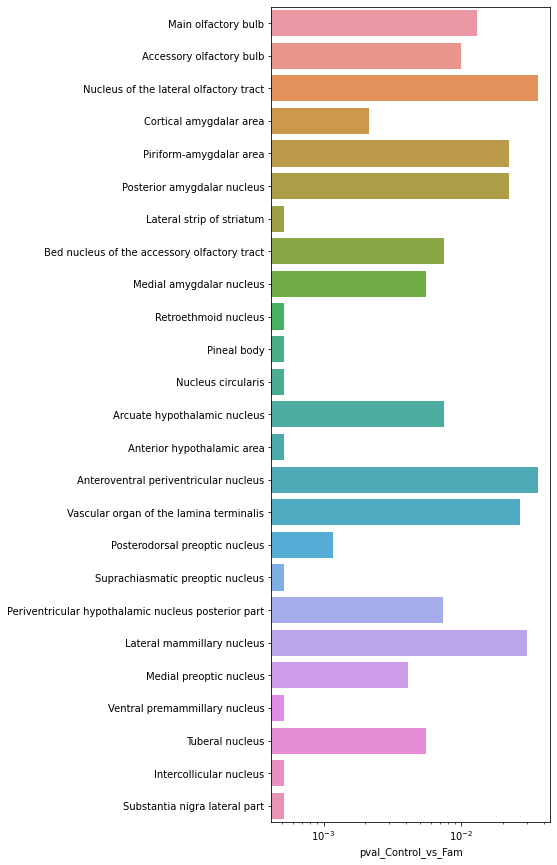

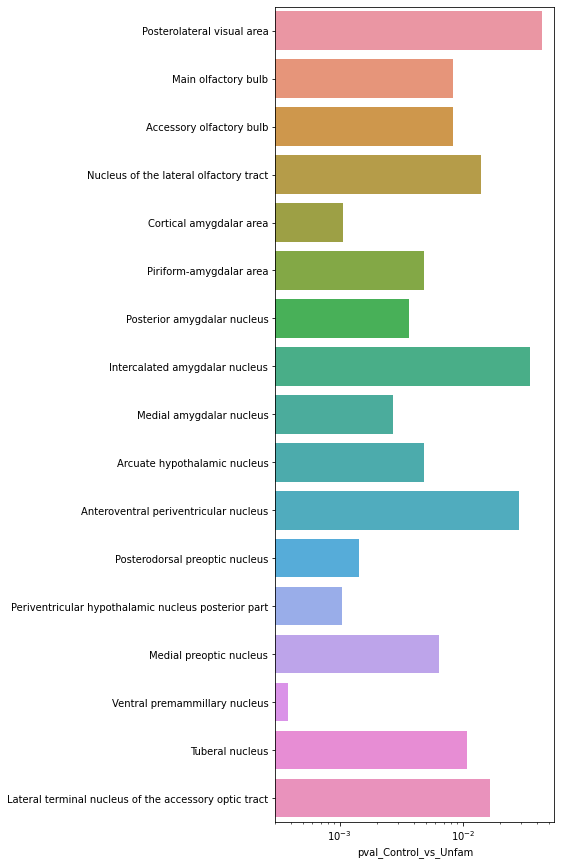

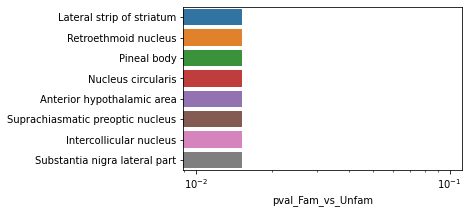

In [71]:
value = 'energy'
df_control_fam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Control_vs_Fam', 
             test='mannwhitneyu', alpha=0.05)
df_control_unfam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Control_vs_Unfam', 
             test='mannwhitneyu', alpha=0.05)
df_fam_unfam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Fam_vs_Unfam', 
             test='mannwhitneyu', alpha=0.05)

#plot control fam
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df_control_fam,
    y="area", x="pval_Control_vs_Fam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

#plot control unfam
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df_control_unfam,
    y="area", x="pval_Control_vs_Unfam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

#plot fam unfam
fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.barplot(
    data=df_fam_unfam,
    y="area", x="pval_Fam_vs_Unfam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

## density

Text(0, 0.5, '')

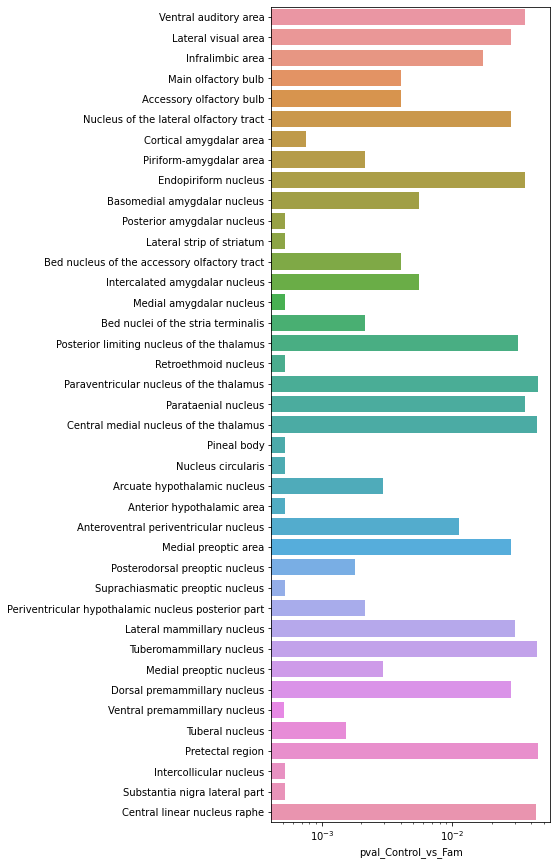

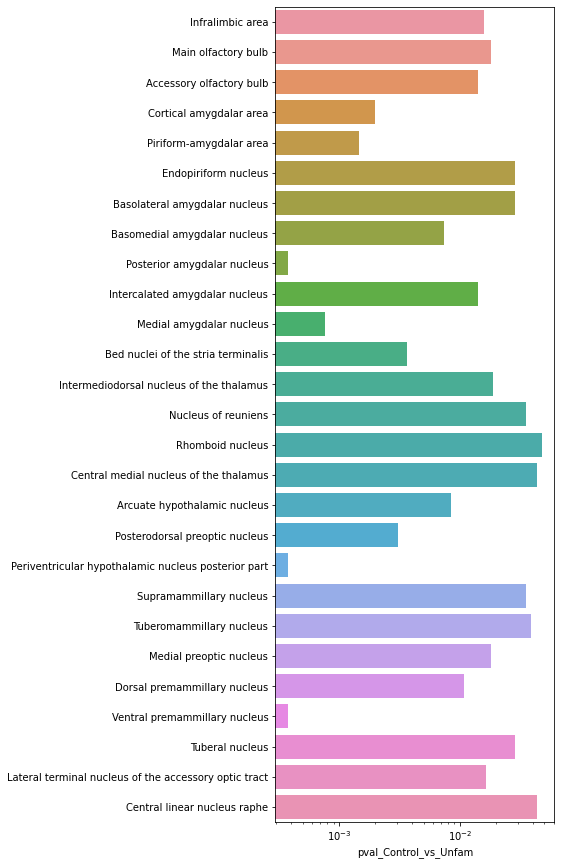

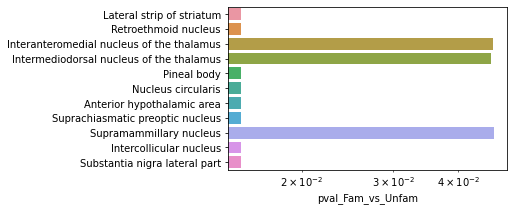

In [72]:
value = 'density'
df_control_fam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Control_vs_Fam', 
             test='mannwhitneyu', alpha=0.05)
df_control_unfam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Control_vs_Unfam', 
             test='mannwhitneyu', alpha=0.05)
df_fam_unfam = find_pvalues(dictionary=dict_results_across_mice, 
             experimental_groups=experimental_groups, 
             value=value, 
             tag='pval_Fam_vs_Unfam', 
             test='mannwhitneyu', alpha=0.05)

#plot control fam
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df_control_fam,
    y="area", x="pval_Control_vs_Fam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

#plot control unfam
fig, ax = plt.subplots(1,1, figsize=(5,15))
sns.barplot(
    data=df_control_unfam,
    y="area", x="pval_Control_vs_Unfam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')

#plot fam unfam
fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.barplot(
    data=df_fam_unfam,
    y="area", x="pval_Fam_vs_Unfam",
    ax=ax)
ax.set_xscale("log")
ax.set_ylabel('')